In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
plt.style.use('seaborn-paper')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 8,
    "font.size": 8,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)
from scipy.stats import kendalltau

In [2]:
DATA_PATH = 'data/measures.csv'
PLOT_DIR = 'plots'
# for reproducibility
SEED = 0
np.random.seed(SEED)

In [3]:
data = pd.read_csv(DATA_PATH, delimiter=';')
data[:10]

,expr,mon_ru,mon_lu,mon_rd,mon_ld,quant,cons_l,cons_r,compl
0,"lambda a, b: len(a) == 0",1.000000,0.305370,1.000000,1.000000,1.0,1.000000,0.817711,232.822977
1,"lambda a, b: len(b) == 0",0.305370,1.000000,1.000000,1.000000,1.0,0.817711,1.000000,232.822977
2,"lambda a, b: len(a) != 0",1.000000,1.000000,1.000000,0.000000,1.0,1.000000,0.795864,232.822977
3,"lambda a, b: len(b) != 0",1.000000,1.000000,0.000000,1.000000,1.0,0.795864,1.000000,232.822977
4,"lambda a, b: set(a) <= set(a)",1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,32.869126
5,"lambda a, b: set(a) <= set(b)",1.000000,0.709964,0.000000,1.000000,1.0,1.000000,0.845380,380.734045
6,"lambda a, b: set(b) <= set(a)",0.709964,1.000000,1.000000,0.000000,1.0,0.845380,1.000000,350.604012
7,"lambda a, b: set(a) < set(a)",1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,32.869126
8,"lambda a, b: set(a) < set(b)",1.000000,0.708838,0.002471,1.000000,1.0,0.997875,0.846679,424.559546
9,"lambda a, b: set(b) < set(a)",0.708838,1.000000,1.000000,0.002471,1.0,0.846679,0.997875,419.081358


In [4]:
# latex compilation complains because of underscores
valid_names = {
        'mon_ru': 'monru',
        'mon_lu': 'monlu',
        'mon_ld': 'monld',
        'mon_rd': 'monrd',
        'cons_l': 'consl',
        'cons_r': 'consr',
}
data = data.rename(columns=valid_names)

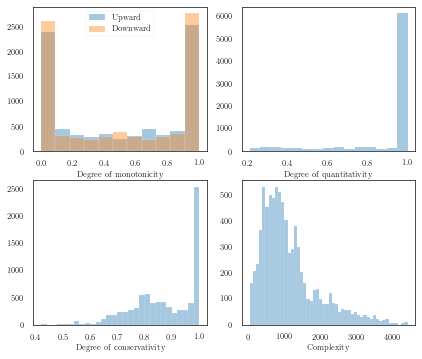

In [5]:
# Plot distribution of each measure
fig = plt.figure(figsize=(6.85, 5.85))
fig.tight_layout()

ax = fig.add_subplot(221)
sns.distplot(data.monru, kde=False, label='Upward', ax=ax)
sns.distplot(data.monrd, kde=False, label='Downward', ax=ax)
ax.legend()
ax.set_xlabel('Degree of monotonicity')

ax = fig.add_subplot(222)
sns.distplot(data.quant, kde=False, ax=ax, bins=15)
ax.set_xlabel('Degree of quantitativity')

ax = fig.add_subplot(223)
sns.distplot(data.consl, kde=False, ax=ax)
ax.set_xlabel('Degree of conservativity')

ax = fig.add_subplot(224)
sns.distplot(data.compl, kde=False, ax=ax)
ax.set_xlabel('Complexity')


plt.savefig(f'{PLOT_DIR}/dists.pdf', dpi=300,
           pad_inches=0, bbox_inches='tight')
plt.show()

In [6]:
data['maxmonr'] = np.maximum(data.monru, data.monrd)
data['maxmonl'] = np.maximum(data.monlu, data.monld)
data['avgmaxmon'] = (data.maxmonr + data.maxmonl) / 2
data['maxmon'] = np.maximum(data.maxmonr, data.maxmonl)
data['maxavgmon'] = np.maximum((data.monlu + data.monru) / 2, (data.monld + data.monrd) / 2)
data['maxcons'] = np.maximum(data.consl, data.consr)
data['avgcons'] = (data.consl + data.consr) / 2

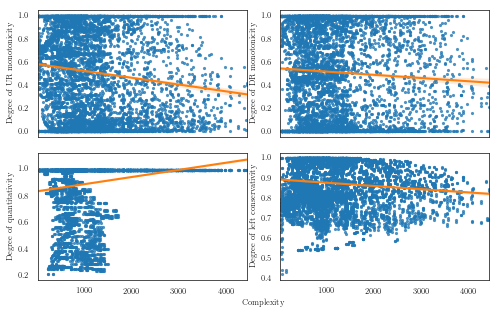

In [7]:
#Regression plots 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(sharex=True, figsize=(6.85, 4.25), nrows=2, ncols=2)
fig.tight_layout()
fig.add_subplot(111, frameon=False)
sns.regplot('compl', 'monru', data, seed=SEED,
           line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax1, n_boot=10000)
ax1.set_ylabel('Degree of UR monotonicity')

sns.regplot('compl', 'monrd', data, seed=SEED,
           line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax2, n_boot=10000)
ax2.set_ylabel('Degree of DR monotonicity')

sns.regplot('compl', 'quant', data, seed=SEED,
            line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax3, n_boot=10000)
ax3.set_ylabel('Degree of quantitativity')

sns.regplot('compl', 'consl', data, seed=SEED,
            line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax4, n_boot=10000)
ax4.set_ylabel('Degree of left conservativity') 

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('')
plt.xlabel('Complexity')

plt.savefig(f'{PLOT_DIR}/reg.pdf', dpi=300,
           pad_inches=0, bbox_inches='tight')
plt.show()

In [8]:
def bootstrap_ci(dataset, y_name, statistic, N=10000):
    observed_stat = statistic(dataset.compl, dataset[y_name])
    resampled_stats = []
    for __ in range(N):
        resampled_indices = np.random.choice(dataset.index, size=len(dataset), replace=True)
        resampled_stat = statistic(dataset.compl[resampled_indices], (dataset[y_name])[resampled_indices])
        resampled_stats.append(resampled_stat)
    resampled_stats = np.array(resampled_stats)
    resampled_stats -= observed_stat
    critical_values = np.percentile(resampled_stats, [97.5, 2.5])
    ci = observed_stat - critical_values
    return observed_stat, ci
    
r_squared = lambda x, y: np.corrcoef(x, y)[0,1] ** 2
tau = lambda x, y: kendalltau(x, y)[0]

In [9]:
print(f"(mon_ru, CI) for R^2: {bootstrap_ci(data, 'monru', r_squared)}")
print(f"(mon_rd, CI) for R^2: {bootstrap_ci(data, 'monrd', r_squared)}")
print(f"(mon_lu, CI) for R^2: {bootstrap_ci(data, 'monlu', r_squared)}")
print(f"(mon_ld, CI) for R^2: {bootstrap_ci(data, 'monld', r_squared)}")
print(f"(max_mon_r, CI) for R^2: {bootstrap_ci(data, 'maxmonr', r_squared)}")
print(f"(max_mon_l, CI) for R^2: {bootstrap_ci(data, 'maxmonl', r_squared)}")
print(f"(avg_max_mon, CI) for R^2: {bootstrap_ci(data, 'avgmaxmon', r_squared)}")
print(f"(max_mon, CI) for R^2: {bootstrap_ci(data, 'maxmon', r_squared)}")
print(f"(max_avg_mon, CI) for R^2: {bootstrap_ci(data, 'maxavgmon', r_squared)}")

print(f"(quant, CI) for R^2: {bootstrap_ci(data, 'quant', r_squared)}")
print(f"(cons_l, CI) for R^2: {bootstrap_ci(data, 'consl', r_squared)}")
print(f"(cons_r, CI) for R^2: {bootstrap_ci(data, 'consr', r_squared)}")
print(f"(max_cons, CI) for R^2: {bootstrap_ci(data, 'maxcons', r_squared)}")
print(f"(avg_cons, CI) for R^2: {bootstrap_ci(data, 'avgcons', r_squared)}")

print()

print(f"(mon_ru, CI) for tau: {bootstrap_ci(data, 'monru', tau)}")
print(f"(mon_rd, CI) for tau: {bootstrap_ci(data, 'monrd', tau)}")
print(f"(mon_lu, CI) for tau: {bootstrap_ci(data, 'monlu', tau)}")
print(f"(mon_ld, CI) for tau: {bootstrap_ci(data, 'monld', tau)}")
print(f"(max_mon_r, CI) for tau: {bootstrap_ci(data, 'maxmonr', tau)}")
print(f"(max_mon_l, CI) for tau: {bootstrap_ci(data, 'maxmonl', tau)}")
print(f"(avg_max_mon, CI) for tau: {bootstrap_ci(data, 'avgmaxmon', tau)}")
print(f"(max_mon, CI) for tau: {bootstrap_ci(data, 'maxmon', tau)}")
print(f"(max_avg_mon, CI) for tau: {bootstrap_ci(data, 'maxavgmon', tau)}")

print(f"(quant, CI) for tau: {bootstrap_ci(data, 'quant', tau)}")
print(f"(cons_l, CI) for tau: {bootstrap_ci(data, 'consl', tau)}")
print(f"(cons_r, CI) for tau: {bootstrap_ci(data, 'consr', tau)}")
print(f"(max_cons, CI) for tau: {bootstrap_ci(data, 'maxcons', tau)}")
print(f"(avg_cons, CI) for tau: {bootstrap_ci(data, 'avgcons', tau)}")


(mon_ru, CI) for R^2: (0.012741177830987757, array([0.00769012, 0.01690126]))
(mon_rd, CI) for R^2: (0.002655069259243755, array([0.00015274, 0.00431569]))
(mon_lu, CI) for R^2: (0.014654209574110755, array([0.00950604, 0.01915386]))
(mon_ld, CI) for R^2: (0.0031356628401255863, array([0.00034044, 0.00498871]))
(max_mon_r, CI) for R^2: (0.019099468817401353, array([0.01274274, 0.02455163]))
(max_mon_l, CI) for R^2: (0.021108471962158287, array([0.0146119 , 0.02688071]))
(avg_max_mon, CI) for R^2: (0.038715127636647355, array([0.03008466, 0.04650093]))
(max_mon, CI) for R^2: (0.026662227102029125, array([0.01840682, 0.03377546]))
(max_avg_mon, CI) for R^2: (0.050690305468184704, array([0.04147946, 0.05927722]))
(quant, CI) for R^2: (0.03991107455795665, array([0.03488825, 0.0446774 ]))
(cons_l, CI) for R^2: (0.012563941396255341, array([0.00782441, 0.01647292]))
(cons_r, CI) for R^2: (0.01573010104503775, array([0.01056425, 0.020131  ]))
(max_cons, CI) for R^2: (0.03480282001163299, arr

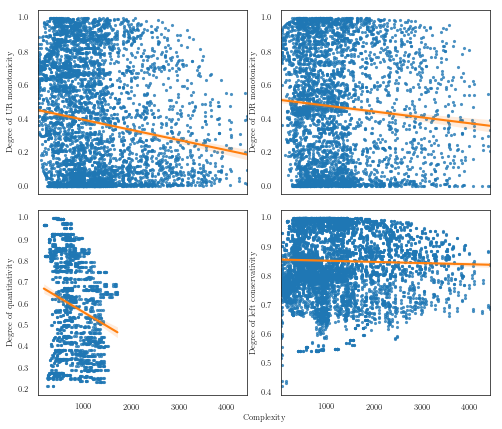

In [10]:
# Removing the 1's and 0's:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(sharex='all', figsize=(6.87, 5.85), nrows=2, ncols=2)
fig.tight_layout()
fig.add_subplot(111, frameon=False)

sns.regplot('compl', 'monru', data[(0 < data.monru) & (data.monru < 1)], seed=SEED,
           line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax1, n_boot=10000)
ax1.set_ylabel('Degree of UR monotonicity')

sns.regplot('compl', 'monrd', data[(0 < data.monrd) & (data.monrd < 1)], seed=SEED,
           line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax2, n_boot=10000)
ax2.set_ylabel('Degree of DR monotonicity')

sns.regplot('compl', 'quant', data[(0 < data.quant) & (data.quant < 1)], seed=SEED,
            line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax3, n_boot=10000)
ax3.set_ylabel('Degree of quantitativity')

sns.regplot('compl', 'consl', data[(0 < data.consl) & (data.consl < 1)], seed=SEED,
            line_kws={'color': sns.color_palette()[1]}, scatter_kws={"s": 10}, ax=ax4, n_boot=10000)
ax4.set_ylabel('Degree of left conservativity') 

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('')
plt.xlabel('Complexity')

# plt.savefig(f'{PLOT_DIR}/reg_modified.pdf', dpi=300,
#            pad_inches=0, bbox_inches='tight')
plt.show()

In [11]:
print('Statistics for modified data with zeros and ones removed')
print(f"(mon_ru, CI) for R^2: {bootstrap_ci(data[(0 < data.monru) & (data.monru < 1)], 'monru', r_squared)}")
print(f"(mon_rd, CI) for R^2: {bootstrap_ci(data[(0 < data.monrd) & (data.monrd < 1)], 'monrd', r_squared)}")
print(f"(mon_lu, CI) for R^2: {bootstrap_ci(data[(0 < data.monlu) & (data.monlu < 1)], 'monlu', r_squared)}")
print(f"(mon_ld, CI) for R^2: {bootstrap_ci(data[(0 < data.monld) & (data.monld < 1)], 'monld', r_squared)}")
print(f"(max_mon_r, CI) for R^2: {bootstrap_ci(data[(0 < data.maxmonr) & (data.maxmonr < 1)], 'maxmonr', r_squared)}")
print(f"(max_mon_l, CI) for R^2: {bootstrap_ci(data[(0 < data.maxmonl) & (data.maxmonl < 1)], 'maxmonl', r_squared)}")
print(f"(avg_max_mon, CI) for R^2: {bootstrap_ci(data[(0 < data.avgmaxmon) & (data.avgmaxmon < 1)], 'avgmaxmon', r_squared)}")
print(f"(max_mon, CI) for R^2: {bootstrap_ci(data[(0 < data.maxmon) & (data.maxmon < 1)], 'maxmon', r_squared)}")
print(f"(max_avg_mon, CI) for R^2: {bootstrap_ci(data[(0 < data.maxavgmon) & (data.maxavgmon < 1)], 'maxavgmon', r_squared)}")

print(f"(quant, CI) for R^2: {bootstrap_ci(data[(0 < data.quant) & (data.quant < 1)], 'quant', r_squared)}")
print(f"(cons_l, CI) for R^2: {bootstrap_ci(data[(0 < data.consl) & (data.consl < 1)], 'consl', r_squared)}")
print(f"(cons_r, CI) for R^2: {bootstrap_ci(data[(0 < data.consr) & (data.consr < 1)], 'consr', r_squared)}")
print(f"(max_cons, CI) for R^2: {bootstrap_ci(data[(0 < data.maxcons) & (data.maxcons < 1)], 'maxcons', r_squared)}")
print(f"(avg_cons, CI) for R^2: {bootstrap_ci(data[(0 < data.avgcons) & (data.avgcons < 1)], 'avgcons', r_squared)}")

print()

print(f"(mon_ru, CI) for tau: {bootstrap_ci(data[(0 < data.monru) & (data.monru < 1)], 'monru', tau)}")
print(f"(mon_rd, CI) for tau: {bootstrap_ci(data[(0 < data.monrd) & (data.monrd < 1)], 'monrd', tau)}")
print(f"(mon_lu, CI) for tau: {bootstrap_ci(data[(0 < data.monlu) & (data.monlu < 1)], 'monlu', tau)}")
print(f"(mon_ld, CI) for tau: {bootstrap_ci(data[(0 < data.monld) & (data.monld < 1)], 'monld', tau)}")
print(f"(max_mon_r, CI) for tau: {bootstrap_ci(data[(0 < data.maxmonr) & (data.maxmonr < 1)], 'maxmonr', tau)}")
print(f"(max_mon_l, CI) for tau: {bootstrap_ci(data[(0 < data.maxmonl) & (data.maxmonl < 1)], 'maxmonl', tau)}")
print(f"(avg_max_mon, CI) for tau: {bootstrap_ci(data[(0 < data.avgmaxmon) & (data.avgmaxmon < 1)], 'avgmaxmon', tau)}")
print(f"(max_mon, CI) for tau: {bootstrap_ci(data[(0 < data.maxmon) & (data.maxmon < 1)], 'maxmon', tau)}")
print(f"(max_avg_mon, CI) for tau: {bootstrap_ci(data[(0 < data.maxavgmon) & (data.maxavgmon < 1)], 'maxavgmon', tau)}")

print(f"(quant, CI) for tau: {bootstrap_ci(data[(0 < data.quant) & (data.quant < 1)], 'quant', tau)}")
print(f"(cons_l, CI) for tau: {bootstrap_ci(data[(0 < data.consl) & (data.consl < 1)], 'consl', tau)}")
print(f"(cons_r, CI) for tau: {bootstrap_ci(data[(0 < data.consr) & (data.consr < 1)], 'consr', tau)}")
print(f"(max_cons, CI) for tau: {bootstrap_ci(data[(0 < data.maxcons) & (data.maxcons < 1)], 'maxcons', tau)}")
print(f"(avg_cons, CI) for tau: {bootstrap_ci(data[(0 < data.avgcons) & (data.avgcons < 1)], 'avgcons', tau)}")

Statistics for modified data with zeros and ones removed
(mon_ru, CI) for R^2: (0.02059556557426744, array([0.01367185, 0.02648401]))
(mon_rd, CI) for R^2: (0.006979180698817284, array([0.00198086, 0.01074875]))
(mon_lu, CI) for R^2: (0.0225057390404848, array([0.01549314, 0.02869844]))
(mon_ld, CI) for R^2: (0.006610501548935817, array([0.00153569, 0.01021992]))
(max_mon_r, CI) for R^2: (0.022918613789437537, array([0.01439257, 0.03030102]))
(max_mon_l, CI) for R^2: (0.023961989694481007, array([0.01524087, 0.03136846]))
(avg_max_mon, CI) for R^2: (0.028621159786818656, array([0.02023959, 0.03589012]))
(max_mon, CI) for R^2: (0.04287137173349252, array([0.02632134, 0.05691444]))
(max_avg_mon, CI) for R^2: (0.050127625320435, array([0.04054613, 0.05905125]))
(quant, CI) for R^2: (0.037653177441793154, array([0.02032289, 0.05189575]))
(cons_l, CI) for R^2: (0.0009680849472451821, array([-0.00077572,  0.00182764]))
(cons_r, CI) for R^2: (0.0017286796638097354, array([-0.00038029,  0.0029